In [5]:
import numpy as np
import matplotlib.pyplot as plt

# See the source ann.py.
from ann import *

# Artificial neural network 

In [9]:
# In the cell the basic usage of ann libraty is demonstrated. 

# Create ANN containing 3-dim input and 2-dim output and 10 hidden neurons.
# The network object stores the network structure and weights.
net = ANN.multilayer(3, 10, 2)
print(f"Input dim {net.indim}, output dim {net.outdim}")

# Create random input.
data = np.random.randn(10, net.indim)

# Create random training samples.
training = np.random.randn(data.shape[0], net.outdim)

# Create loss functions computing mean square error with 'training' data.
lossfun = MSE(training)

# Loss function on the training set itself should be equals zero.
loss, _ = lossfun(training)
assert loss == 0.

# Apply the network to the input. 
prediction = net(data)

# Compute the loss function on the prediction.
# `loss` is the value of the loss function.
# `grad_x` is the gradient of the loss with respect to the input `data`.
loss, grad_x = lossfun(prediction)

# We can also differentiate the loss with respect to the weights of the network doing backpropagation. 
# Here `loss` and `grad_x` is as above, but we do not apply `net` to `data`, this happens during execution of the method `propagate`.
# `grad_net` is an ANN object with te same structure as `net`, its weights however contains gradients of the loss with respect to weights of `net`. 
loss, grad_x, grad_net = lossfun.propagate(net=net, x=data)

Input dim 3, output dim 2


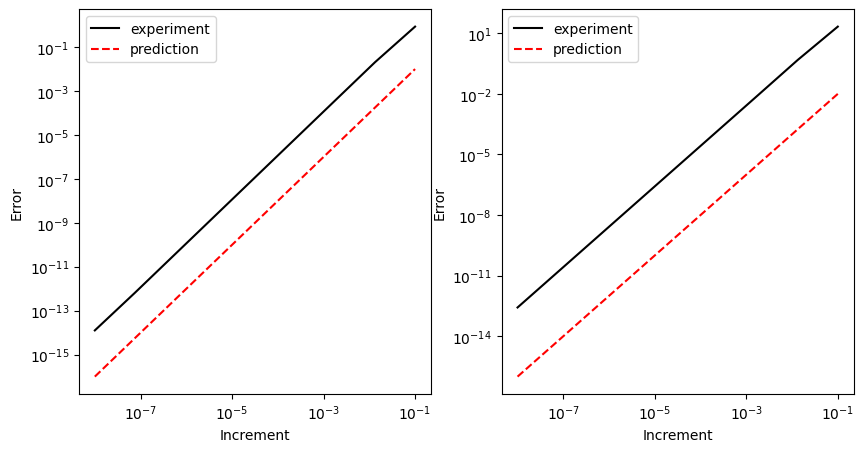

In [11]:
# Error are always possible and are rather expected.
# Here we have independently defined and computed the loss and the gradient of loss.
# It is crucial for training to have the correct gradient.
# Here we check error of Teylor formula approximation using gradient.
# The error is expected to be equal `h^2` as argument step `h` tends to zero.
# The theretical prediction and computed value must have the same slope in the plot below.

def plot_error_x(lossfun, net, x):
    """
    Plot error of approximation of loss function by its differential.
    f(x+eps*f'(x)) = f(x) + f'(x)^2 * eps + O(eps^2)
    """
    l0, grad_x, grad_net = lossfun.propagate(net=net, x=x)
    epses = np.logspace(-8,-1,9)
    errors = np.empty_like(epses)
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
    
    s = np.sum(grad_x*grad_x)
    for n, eps in enumerate(epses):
        x1 = x + grad_x*eps
        l1, _, _ = lossfun.propagate(net=net, x=x1)
        errors[n] = np.abs(l1-l0-s*eps)
    
    ax1.loglog(epses, errors, '-k', label='experiment')
    ax1.loglog(epses, epses**2, '--r', label='prediction')
    ax1.set_xlabel("Increment")
    ax1.set_ylabel("Error")
    ax1.legend()
    
    s = grad_net*grad_net
    for n, eps in enumerate(epses):
        net1 = net + grad_net*eps
        l1, _, _ = lossfun.propagate(net=net1, x=x)
        errors[n] = np.abs(l1-l0-s*eps)
    
    ax2.loglog(epses, errors, '-k', label='experiment')
    ax2.loglog(epses, epses**2, '--r', label='prediction')
    ax2.set_xlabel("Increment")
    ax2.set_ylabel("Error")
    ax2.legend()
    
    plt.show()
    
    
net = ANN.multilayer(3, 10, 2)
data = np.random.randn(1, net.indim)
observed = np.random.randn(data.shape[0], net.outdim)
lossfun = MSE(observed)   
plot_error_x(lossfun, net, data)

# Training

In [155]:
# Here we define simple benchmark, where neural network is used to approximate sin function.
# First we define abstract class for benchmarks.

class Benchmark:
    def train(self, batchsize, method, net=None, **kwargs):
        """
        The function is used to train artificial network `net` using `method` (e.g. `ann.steepest_descent`
        or `ann.lbfgs`).
        The training is done on a random batch of size `batchsize`.
        Keyword arguments are passed as is to the training `method`.
        """
        x, y = self.generate(count=batchsize)
        if net is None:
            net = self.network()
        lossfun = self.lossclass(y)
        net = method(net=net, lossfun=lossfun, x=x, **kwargs)

        y1 = net(x)
        loss, _ = lossfun(y1)
        print("Training error:", loss)
        
        return net
    
    def test(self, net, batchsize):
        """
        Apply the trained `net` to a random samples set of size `batchsize`,
        compute the loss function and report the results.
        """
        x, y = self.generate(count=batchsize)
        lossfun = self.lossclass(y)
        y1 = net(x)
        loss, _ = lossfun(y1)
        print("Generalization error:", loss)
        fig, ax1 = plt.subplots(figsize=(7,5))        
        self.plot(x,y1,ax=ax1,style='.r',label='learned')
        self.plot(x,y,ax=ax1,style='.k',label='correct')        
        plt.show()
        return loss
    
    def plot(self, x, y, style='.', label=None):
        """
        Plot network input `y` with respect to the network input `x`.
        """
        raise NotImplementedError

class SinBenchmark(Benchmark):
    """
    In the benchmark an ANN is used to approximate `sin` function minimizing the mean square error
    in the interval [0,pi].
    """
    def __init__(self, amplitude=1, period=0.25, phase=0., segment=2*np.pi):
        """
        Create instance of the test with `sin` function having given `amplitude`, `period` and `phase`:
        f(x) = amplitude * sin(x/period + phase),
        where `x` and `phase` are in radians.
        """
        self._amplitude = amplitude
        self._period = period
        self._phase = phase
        self._segment = segment
  
    def plot(self, x, y, ax, style='.', label=None):
        """
        Plot `y` as function of `x`.
        """
        ax.plot(x, y, style, label=label)

    def fun(self, x):
        """
        Compute the ideal `sin` function on the vector `x`.
        """
        return self._amplitude*np.sin(x/self._period+self._phase)
    
    def generate(self, count):
        """
        Generate training set consisting of the inputs `x` and the corresponding `outputs`.
        """
        x = np.random.rand(count, 1)*self._segment
        y = self.fun(x)
        return x, y
    
    @property
    def lossclass(self):
        """
        Loss function to use to measure approximation error.
        """
        return MSE
    
    def network(self):
        """
        Return artificial network capable of approximation of `fun` with random weights.
        """
        return ANN.multilayer(1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1)

In [193]:
# Create the benchmark object and show network structure.
bench = SinBenchmark()
net = bench.network()
print(net)

((((((((((((((((((1x10@Atan)@10x10)@Atan)@10x10)@Atan)@10x10)@Atan)@10x10)@Atan)@10x10)@Atan)@10x10)@Atan)@10x10)@Atan)@10x10)@Atan)@10x1)


In [194]:
# Train the net using naive gradient descent.
# net = bench.train(batchsize=1000, method=steepest_descent, net=net)
# bench.test(net=net, batchsize=100)

0: loss 0.05153058323154127 grad 3.315613736188065
100: loss 0.04322477118848354 grad 0.5011971915603428
200: loss 0.04072000280112813 grad 0.8325236381112355
300: loss 0.03888320823604549 grad 0.7233617902298408
400: loss 0.03744875433619399 grad 0.31906445444070813
Training error: 0.03630750720816579
Generalization error: 0.04254066432272633


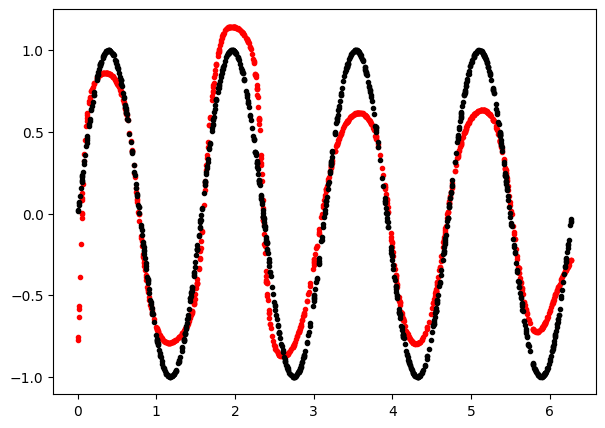

0: loss 0.04198760223082953 grad 2.5799887553293943
100: loss 0.038144813057726316 grad 0.41208949278334817
200: loss 0.03711667835949413 grad 0.5873814264409133
300: loss 0.03635544143995762 grad 0.26376142687970305
400: loss 0.03570208550700368 grad 0.24680545516200805
Training error: 0.03511998651468685
Generalization error: 0.04139444638722874


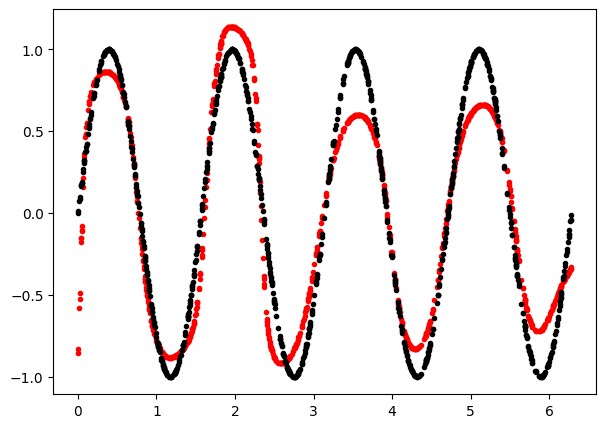

0: loss 0.026836573110026116 grad 1.9375281355334377
100: loss 0.024745094174934937 grad 0.4634344620592391
200: loss 0.02395926765606867 grad 0.4578070760008282
300: loss 0.023455883763980577 grad 0.19066717047634416
400: loss 0.02307126170825605 grad 0.17115511897221264
Training error: 0.022744472795971745
Generalization error: 0.04214190601670032


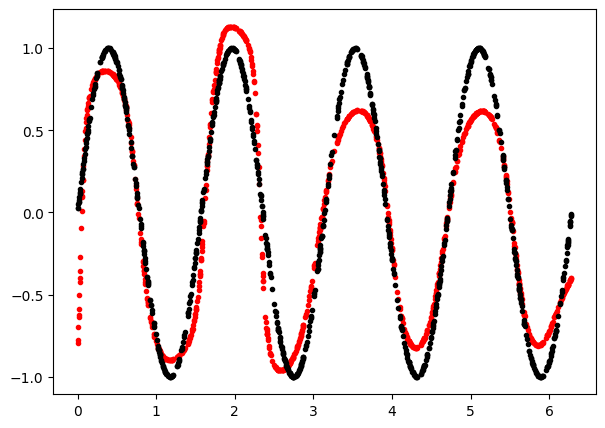

0: loss 0.03778374634856369 grad 1.2709965484029573
100: loss 0.03361762898050119 grad 0.29427673194922266
200: loss 0.032733116159981646 grad 0.2322396461465687
300: loss 0.032141483636004914 grad 0.19624196490694187
400: loss 0.03169704115024912 grad 0.17485655509648904
Training error: 0.03133038991815184
Generalization error: 0.03778436691756091


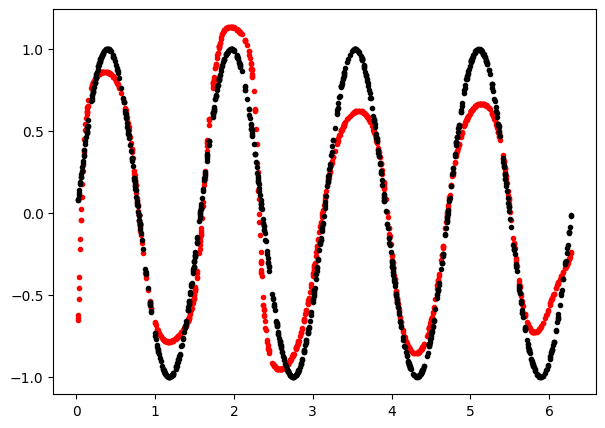

0: loss 0.04453027588169855 grad 2.191029609286697
100: loss 0.04147132077734958 grad 0.5001536514977986
200: loss 0.04037616802950792 grad 0.3370459610840353
300: loss 0.0396498468470116 grad 0.37002693635721323
400: loss 0.039072770150986924 grad 0.33964568506456183
Training error: 0.03855137877135215
Generalization error: 0.040572028186435266


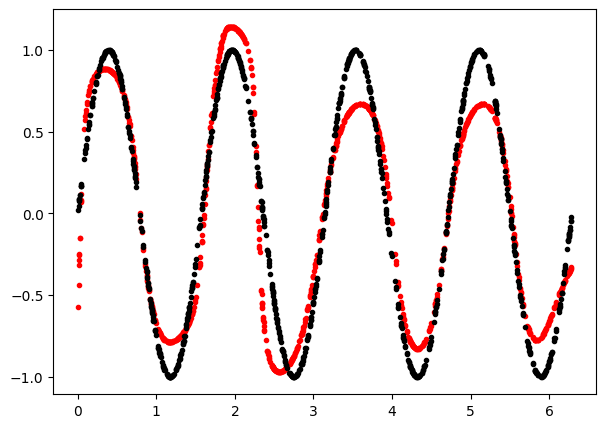

0: loss 0.04444745811967073 grad 2.3320234946477854
100: loss 0.033869714121353194 grad 0.6524843581815114
200: loss 0.03268123816896633 grad 0.22744256750126607
300: loss 0.032007234739500075 grad 0.18383652975422538
400: loss 0.031513740563924905 grad 0.16242237909989474
Training error: 0.031098405363451844
Generalization error: 0.033266280246993796


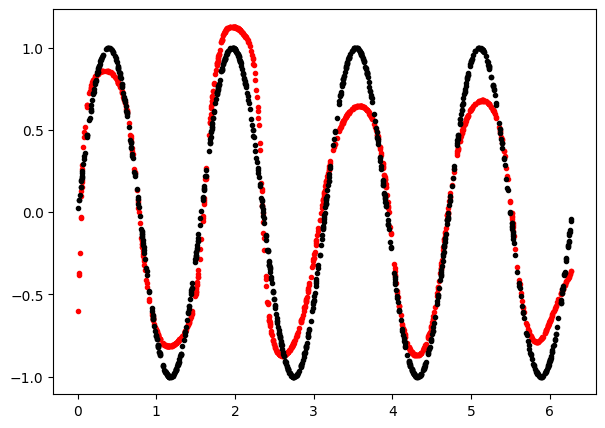

0: loss 0.03176647466784722 grad 2.8303109958535146
100: loss 0.029609090215462673 grad 0.3726383454175726
200: loss 0.02908854356844147 grad 0.17683182445790688
300: loss 0.028821079998089128 grad 0.20644146238958946
400: loss 0.028638538512802035 grad 0.23482674446452362
Training error: 0.028486268836423464
Generalization error: 0.031132466766254245


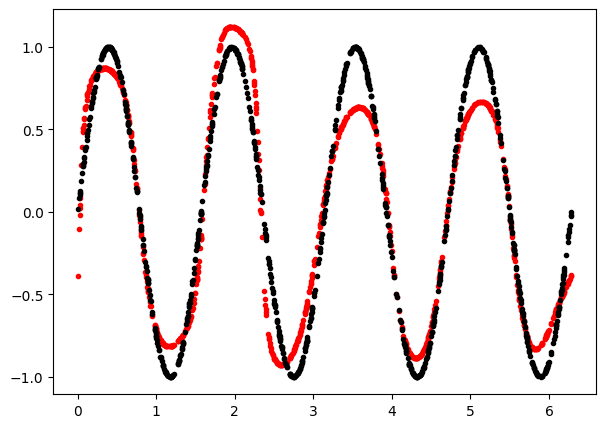

0: loss 0.03263516122864779 grad 1.5608571148424557
100: loss 0.03155161323657265 grad 0.2489138886652159
200: loss 0.031185896993141386 grad 0.23761021621511225
300: loss 0.030843519558531665 grad 0.23314153749939834
400: loss 0.030512267437976606 grad 0.23101956696006218
Training error: 0.03018697117174731
Generalization error: 0.03315228834049889


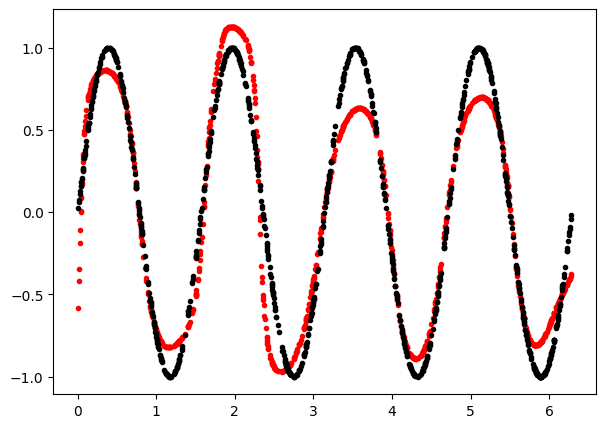

0: loss 0.03268921305981552 grad 1.8223705695241754
100: loss 0.031476516775425255 grad 0.1499263706535847
200: loss 0.03122321605629431 grad 0.2503782577321561
300: loss 0.030995397340673955 grad 0.2395756000083428
400: loss 0.030784791613984307 grad 0.23145088480853332
Training error: 0.030583801423817274
Generalization error: 0.030782844027782315


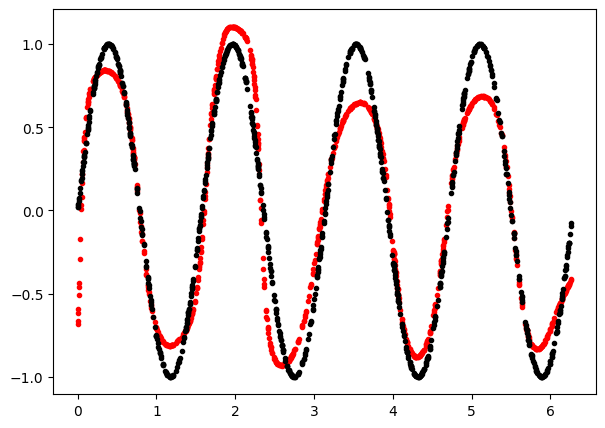

0: loss 0.03366459777160499 grad 3.265032875975856
100: loss 0.030216650525077514 grad 0.5848229243227835
200: loss 0.028985776381844953 grad 0.44461617865395636
300: loss 0.028254135511687185 grad 0.35766668209578273
400: loss 0.027768481412434442 grad 0.3025337175924378
Training error: 0.0274126545188391
Generalization error: 0.030658269796125702


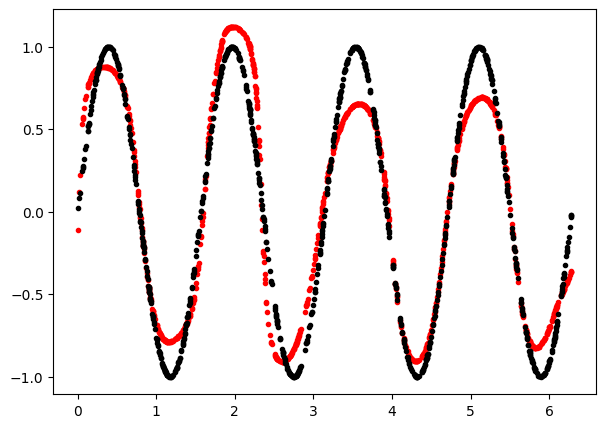

In [199]:
# Train network using L-BFGS and check the result.
# The cell can be run multiple time to repeat training, each time training set is new.
for n in range(10):
    net = bench.train(batchsize=100, method=lbfgs, net=net, maxiter=500)
    bench.test(net=net, batchsize=1000)

Generalization error: 9.626120803748421


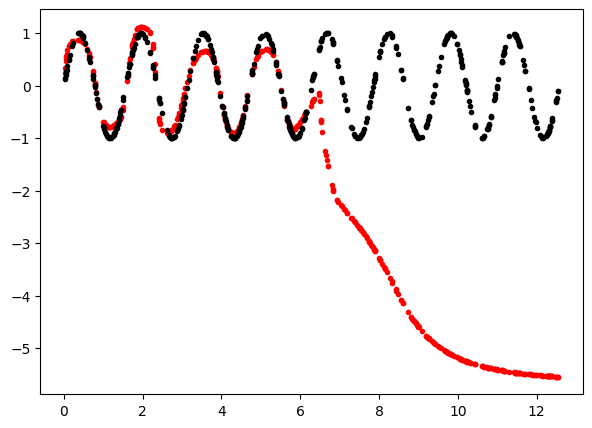

9.626120803748421

In [200]:
# Check, if network makes good prediction outside of the interval, which was used for training.
# This is unlikely, but if the deep network unterstood what the periodicity is, this is possible.

bench2 = SinBenchmark(segment = 4*np.pi)
bench2.test(net=net, batchsize=500)

# Autoencoder

In [201]:
class SpiralBenchmark(Benchmark):
    def __init__(self, max_phi=7, delta_rho=0.1):
        self._max_phi = max_phi
        self._delta_rho = delta_rho
  
    def plot(self, x, y, ax, style='.', label=None):
        ax.plot(y[...,0], y[...,1], style, label=label)

    def fun(self, x):
        return x.copy()
    
    def generate(self, count):
        phi = np.random.rand(count)*self._max_phi
        r = phi+np.random.randn(count)*self._delta_rho
        x, y = np.cos(phi)*r, np.sin(phi)*r
        data = np.stack((x,y), axis=-1)
        return data, data
    
    @property
    def lossclass(self):
        return MSE
    
    # Autoencoder network
    def network(self, noise=0.01):
        encoder = ANN.multilayer(2, 10, 10, 10, 10, 1, noise=noise)
        decoder = ANN.multilayer(1, 10, 10, 10, 10, 2, noise=noise)
        return decoder @ encoder
        
    # Trivial alternative to the autoencoder above (no bottleneck).
#     def network(self, noise=1.0):
#         return ANN.multilayer(2, 2, 2, activation=Id, noise=noise)


In [202]:
# Initialize benchark
bench = SpiralBenchmark()
net = bench.network()
print(net)

(((((((((((((((((2x10@Atan)@10x10)@Atan)@10x10)@Atan)@10x10)@Atan)@10x1)@1x10)@Atan)@10x10)@Atan)@10x10)@Atan)@10x10)@Atan)@10x2)


Generalization error: 7.7737646203285165


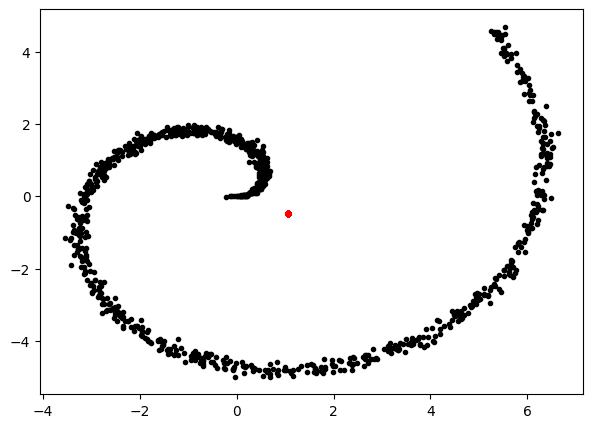

Epoch 0
Training error: 0.2044145596592999
Generalization error: 0.6743914335316624


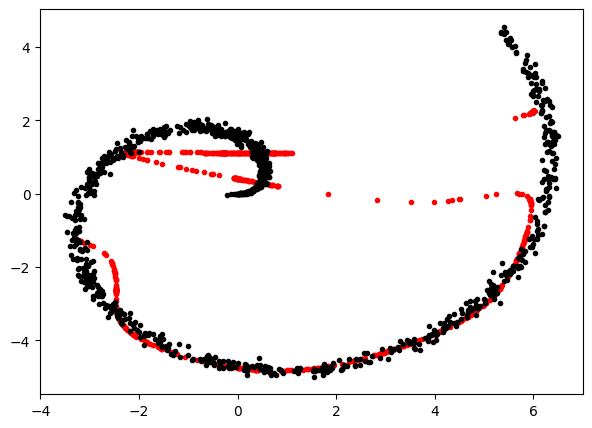

Epoch 1
Training error: 0.18909432386721797
Generalization error: 0.40019616798239943


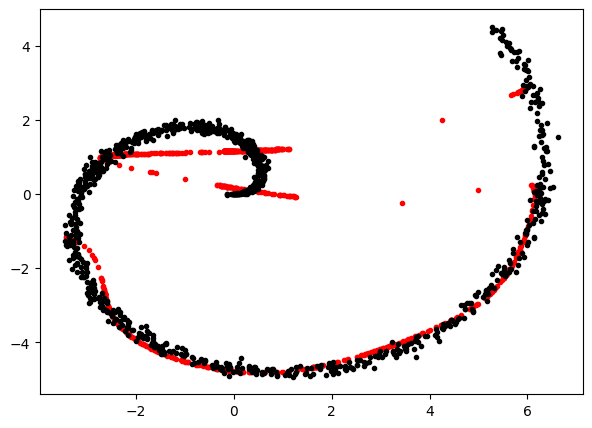

Epoch 2
Training error: 0.16086129316513179
Generalization error: 0.2887107499410295


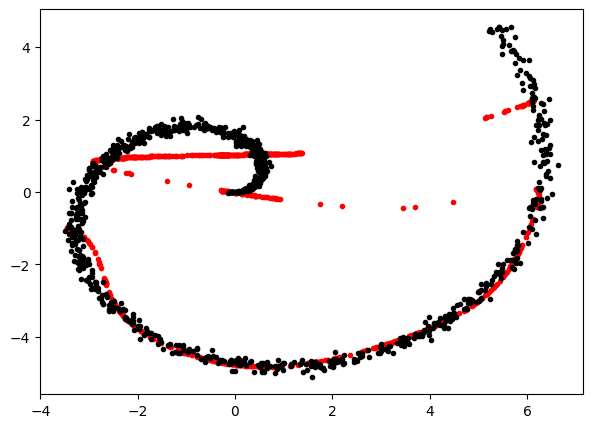

Epoch 3
Training error: 0.11741526812662176
Generalization error: 0.3342077936418557


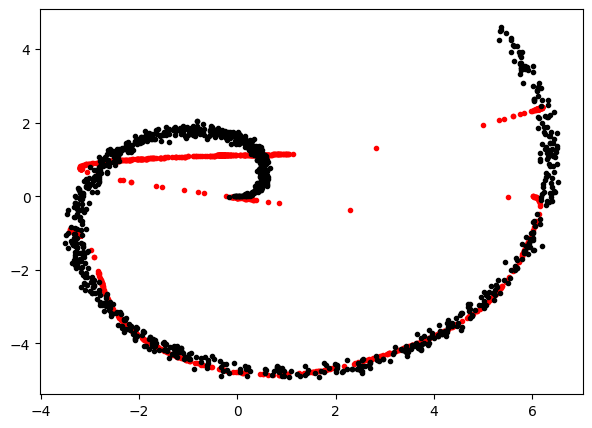

Epoch 4
Training error: 0.14780542500125768
Generalization error: 0.5609769496111696


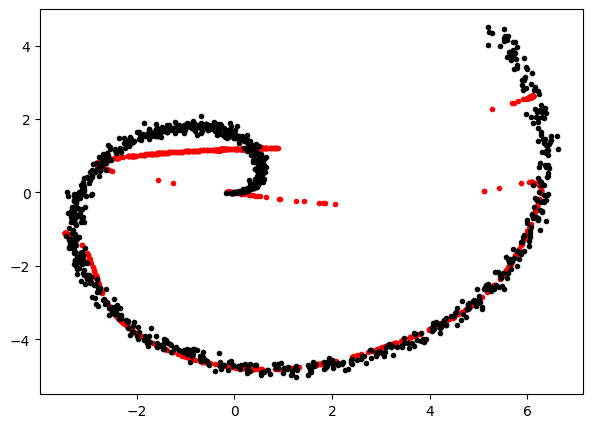

Epoch 5
Training error: 0.12314821230341083
Generalization error: 0.3103487085674674


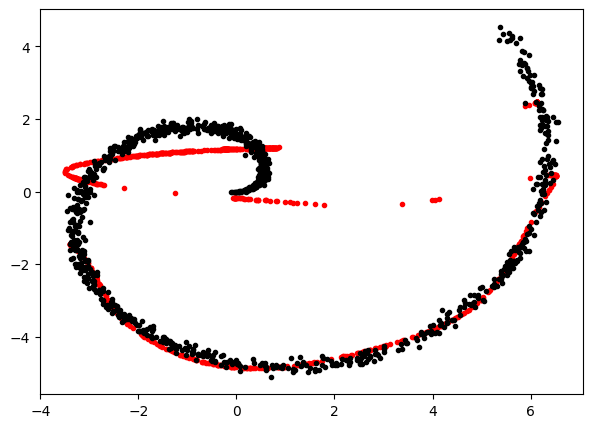

Epoch 6
Training error: 0.1587132859771219
Generalization error: 0.3802608464549775


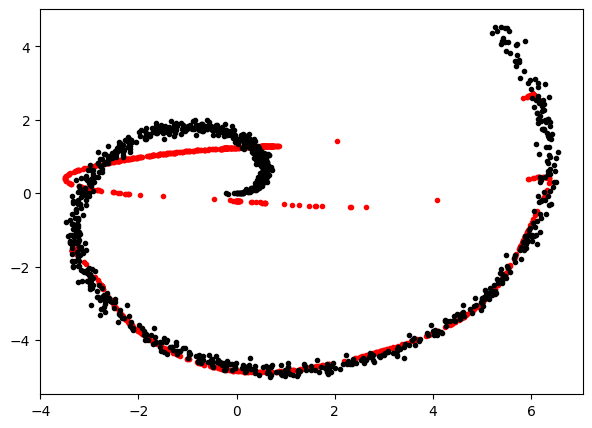

Epoch 7
Training error: 0.10341583208963355
Generalization error: 0.33130030020015294


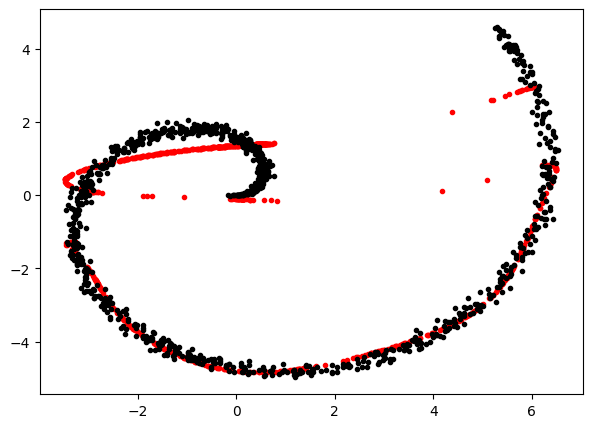

Epoch 8
Training error: 0.052411364472124904
Generalization error: 0.3256529069739223


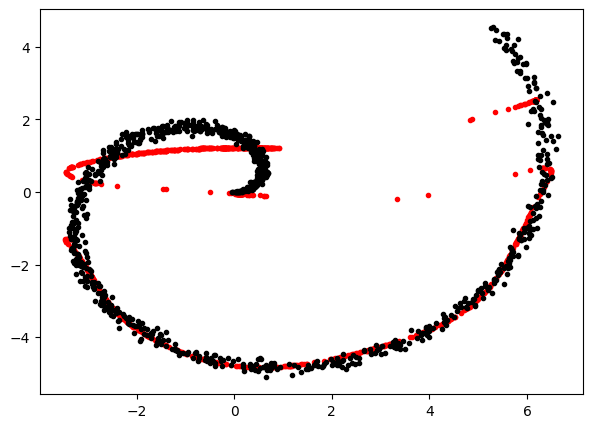

Epoch 9
Training error: 0.08465340137641643
Generalization error: 0.6241568759674627


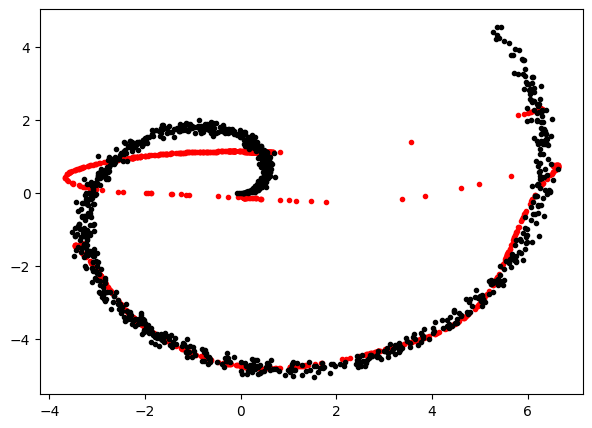

In [203]:
# Network training and testing
bench.test(net=net, batchsize=1000)
for epoch in range(10):
    print(f"Epoch {epoch}")
    net = bench.train(batchsize=100, method=lbfgs, net=net, maxiter=1000, verbosity=0)
    bench.test(net=net, batchsize=1000)